#  **04: Fine Tunning - TweetEval**
### José Eduardo Viveros Escamilla | A01710605
Objetivo:
- Cargar el modelo base entrenado con Sentiment140 (deeptweet_v1_base.h5)
- Cargar el dataset moderno procesado (v2_modern)
- Realizar fine-tuning con learning rate pequeño
- Obtener un modelo actualizado: deeptweet_v2_modern.h5

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

Cargamos los 

In [ ]:
DATA_DIR = "data/processed_data/v2_modern/"

X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(DATA_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "X_test.npy"))

y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test.npy"))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((35458, 50), (11820, 50), (11820, 50), (35458,), (11820,), (11820,))

Cargamos nuestro modelo base que hicimos con el primer dataset

In [3]:
MODEL_V1_PATH = "models/deeptweet_v1_base.h5"

base_model = load_model(MODEL_V1_PATH)
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (256, 50, 150)         │     3,000,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (256, 50, 160)         │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (256, 160)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 1)               │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,153 (12.01 MB)

 Trainable params: 3,148,151 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Para fine-tuning suave, muchas veces se congela parte de las capas y se deja entrenable la parte final

In [4]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (256, 50, 150)         │     3,000,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (256, 50, 160)         │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (256, 160)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 1)               │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,153 (12.01 MB)

 Trainable params: 148,001 (578.13 KB)

 Non-trainable params: 3,000,150 (11.44 MB)

 Optimizer params: 2 (12.00 B)

Esto practicamente nos dice 
* Congelamos TODAS las capas menos las 2 últimas
* Ajustamos solo la parte de arriba con el nuevo dataset

En esta sección compilo el modelo base (deeptweet_v1_base.h5) con un learning rate pequeño (1e-4) para realizar fine-tuning suave.

Congelar capas previas evita que el modelo “olvide” lo aprendido con Sentiment140, mientras que las últimas capas sí se ajustan al lenguaje moderno del dataset TweetEval.

In [5]:
# Compilar el modelo con un learning rate bajo para fine-tuning
optimizer = Adam(learning_rate=5e-5)

base_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print("Modelo compilado")


Modelo compilado


El optimizador Adam con LR bajo permite actualizaciones lentas, lo cual es ideal cuando se re-entrena un modelo preentrenado.

Durante el entrenamiento utilizo callbacks para mejorar estabilidad.
 * EarlyStopping: detiene el entrenamiento si la val_loss deja de mejorar.
 * ModelCheckpoint: guarda automáticamente el mejor modelo.
 * ReduceLROnPlateau: reduce el learning rate cuando el progreso se estanca.
Estos mecanismos estabilizan el fine-tuning y evitan sobreajuste.

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="models/deeptweet_v2_modern.h5",
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6
    )
]

print("Callbacks configurados")


Callbacks configurados


En esta sección realizo el fine-tuning del modelo base utilizando el dataset moderno procesado (TweetEval binario).

Solo ajusto los pesos finales del modelo, utilizando un learning rate pequeño. Esto permite que el modelo actualice su entendimiento del lenguaje moderno sin perder el conocimiento previo adquirido del dataset Sentiment140.
Entreno con un número reducido de épocas (3–5) porque:

1. el modelo ya está preentrenado 
2. el dataset moderno es más pequeño
3. un entrenamiento más largo podría provocar sobreajuste

Durante el entrenamiento monitorizo la validation loss para seleccionar automáticamente el mejor modelo.

In [12]:
EPOCHS = 10
BATCH_SIZE = 128

history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7769 - loss: 0.4695

278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.7736 - loss: 0.4733 - val_accuracy: 0.7704 - val_loss: 0.4778 - learning_rate: 5.0000e-05
Epoch 2/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7752 - loss: 0.4701

278/278 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7741 - loss: 0.4711 - val_accuracy: 0.7701 - val_loss: 0.4765 - learning_rate: 5.0000e-05
Epoch 3/10
276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7792 - loss: 0.4661

278/278 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7757 - loss: 0.4694 - val_accuracy: 0.7720 - val_loss: 0.4750 - learning_rate: 5.0000e-05
Epoch 4/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7780 - loss: 0.4649

278/278 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7759 - loss: 0.4677 - val_accuracy: 0.7730 - val_loss: 0.4742 - learning_rate: 5.0000e-05
Epoch 5/10
276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7749 - loss: 0.4708

278/278 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7775 - loss: 0.4671 - val_accuracy: 0.7721 - val_loss: 0.4740 - learning_rate: 5.0000e-05
Epoch 6/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7773 - loss: 0.4651

278/278 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7776 - loss: 0.4662 - val_accuracy: 0.7746 - val_loss: 0.4718 - learning_rate: 5.0000e-05
Epoch 7/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7775 - loss: 0.4675

278/278 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7796 - loss: 0.4648 - val_accuracy: 0.7755 - val_loss: 0.4708 - learning_rate: 5.0000e-05
Epoch 8/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7802 - loss: 0.4634

278/278 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7788 - loss: 0.4638 - val_accuracy: 0.7758 - val_loss: 0.4697 - learning_rate: 5.0000e-05
Epoch 9/10
276/278 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7785 - loss: 0.4636

278/278 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7790 - loss: 0.4631 - val_accuracy: 0.7761 - val_loss: 0.4690 - learning_rate: 5.0000e-05
Epoch 10/10
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7763 - loss: 0.4657

278/278 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7815 - loss: 0.4609 - val_accuracy: 0.7761 - val_loss: 0.4679 - learning_rate: 5.0000e-05


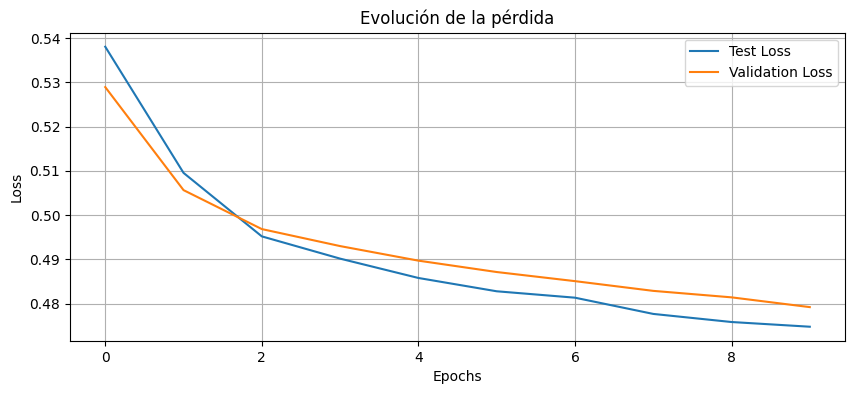

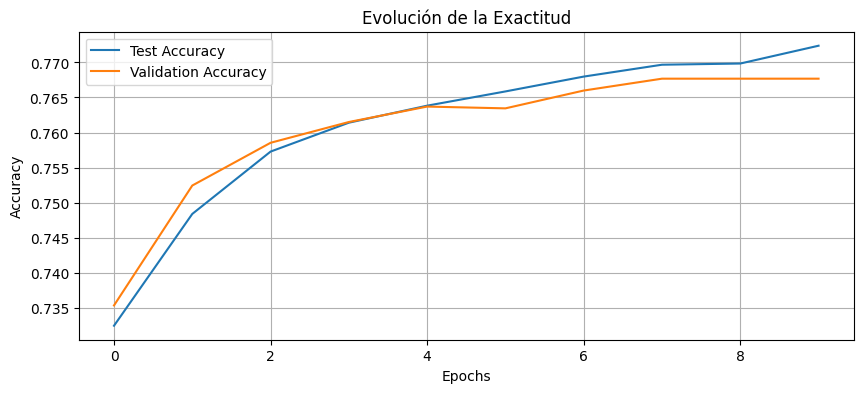

In [11]:
# Gráfica de pérdida (loss)
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Evolución de la pérdida")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de exactitud (accuracy)
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Evolución de la Exactitud")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Ahora evalúo el modelo final entrenado (v2_modern) en el conjunto de prueba (test), el cual no fue utilizado durante el entrenamiento ni la validación.

In [9]:
test_loss, test_acc = base_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7709 - loss: 0.4808
Test Accuracy: 0.7709
Test Loss: 0.4808


370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


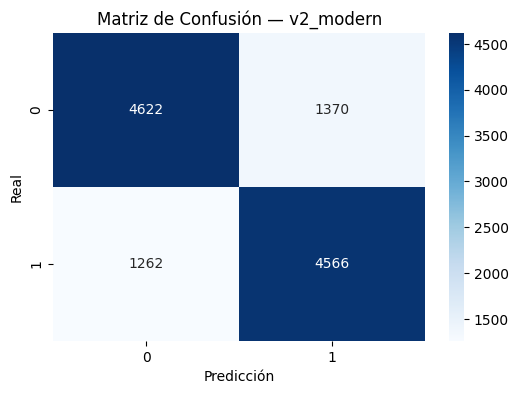

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78      5992
    Positive       0.77      0.78      0.78      5828

    accuracy                           0.78     11820
   macro avg       0.78      0.78      0.78     11820
weighted avg       0.78      0.78      0.78     11820



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (base_model.predict(X_test) > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión — v2_modern")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reporte detallado
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))